In [1]:
import scanpy
import pandas as pd
import magic, scprep
import numpy as np
import matplotlib.pyplot as plt

# Map Vehicle-STZ cells to OB/OB cells

In [2]:
# Get our beta cell dataset and STZ dataset (only treated cells for mapping to OB/OB)

adata_beta = scanpy.read_h5ad('../data/beta_run_2.h5ad')
stz = scanpy.read_h5ad('data/stz_beta_ins1_ins2.h5ad')
stz_treated = stz[stz.obs.treatment == 'Vehicle-STZ']

In [5]:
# Get OB/OB PC operator and OB/OB PCs

obob_pc_op = pd.read_pickle('../analysis_archetypes/results/OB_OB_magic_pc_op.pkl')
obob_magic_pc_norm = pd.read_pickle('../analysis_archetypes/results/OB_OB_magic_pc_norm.pkl')

In [6]:
# Get scMMGAN mapped data and map to obob PCs

out = np.load('results/output_stz_to_obob_cycle_1_correspondence_lambda_10_corr_correspondence_training_counter_15000.npz')
treated_magan = pd.DataFrame(out['stz_to_obob'], index=stz_treated.obs_names, columns=adata_beta.var_names)
treated_magan_magic_pc = obob_pc_op.transform(treated_magan)
treated_magan_magic_pc_norm = treated_magan_magic_pc / np.std(treated_magan_magic_pc[:, 0])

<Axes3D: xlabel='PC1', ylabel='PC2', zlabel='PC3'>

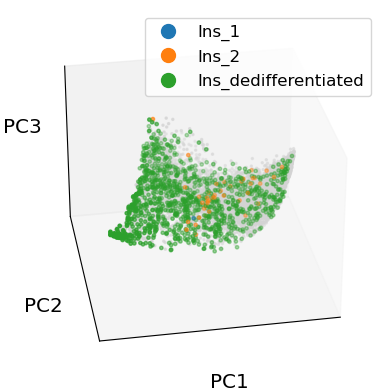

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scprep.plot.scatter3d(obob_magic_pc_norm, azim=440, ax=ax, c='lightgray', ticks=None)
scprep.plot.scatter3d(treated_magan_magic_pc_norm, azim=440, ax=ax, c=stz_treated.obs.groups_named_fine)

## AAnet

In [8]:
import sklearn, torch, sys
sys.path.append('~/bin/AAnet/') # location of AAnet
from AAnet_torch import *

In [9]:
N_ARCHETYPES = 3

In [10]:
device = torch.device('cpu')
model = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                             n_archetypes=N_ARCHETYPES, 
                             input_shape=obob_magic_pc_norm.shape[1],
                             device=device)

In [11]:
data_loader = torch.utils.data.DataLoader(treated_magan_magic_pc_norm, batch_size=256, shuffle=True, num_workers=4)

In [12]:
model.load_state_dict(torch.load('../analysis_archetypes/results/OB_OB_3_model_state_dict'))

<All keys matched successfully>

In [13]:
archetypal_embedding = model.encode(torch.Tensor(treated_magan_magic_pc_norm))
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()

In [14]:
at_dist = []
for row in barycentric_archetypal_embedding:
    id = np.argwhere(row > 0.5)
    if len(id) == 1:
        at_dist.append('OB/OB AT ' + str(id[0][0]+1))
        
    else:
        at_dist.append('Uncommitted')
        
treated_at_comms = pd.Series(at_dist, index = stz_treated.obs_names)

In [15]:
treated_at_comms.to_csv('results/treated_at_comms.csv')

In [17]:
trajectorynet_timepoints = np.argmax(barycentric_archetypal_embedding, axis=1)
trajectorynet_timepoints = scprep.utils.sort_clusters_by_values(trajectorynet_timepoints, treated_magan_magic_pc_norm)

In [22]:
np.save('results/stz_at_clust.npy', trajectorynet_timepoints)

## Run 2

In [7]:
path = 'results/output_run_2_stz_to_obob_cycle_1_correspondence_lambda_10_corr_correspondence.npz'

In [9]:
adata_beta_obob = adata_beta[adata_beta.obs['samples'] == 'OB/OB']
adata_beta_obob = adata_beta_obob[:, adata_beta[:, ~adata_beta.var['names'].duplicated()].var.index]

In [11]:
from sklearn import decomposition

In [12]:
data_magic_op = magic.MAGIC(random_state=42, t=10, verbose=False)
data_magic = data_magic_op.fit_transform(adata_beta_obob.to_df())

data_pc_op = decomposition.PCA(n_components=20, random_state=42)
data_magic_pc = data_pc_op.fit_transform(data_magic)
data_magic_pc_norm = data_magic_pc / np.std(data_magic_pc[:, 0])

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


  Running MAGIC with `solver='exact'` on 16479-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.


In [15]:
# Get scMMGAN mapped data and map to obob PCs

out = np.load(path)
treated_magan = pd.DataFrame(out['stz_to_obob'], index=stz_treated.obs_names, columns=adata_beta_obob.var_names)
treated_magan_magic_pc = data_pc_op.transform(treated_magan)
treated_magan_magic_pc_norm = treated_magan_magic_pc / np.std(treated_magan_magic_pc[:, 0])

<Axes3D: >

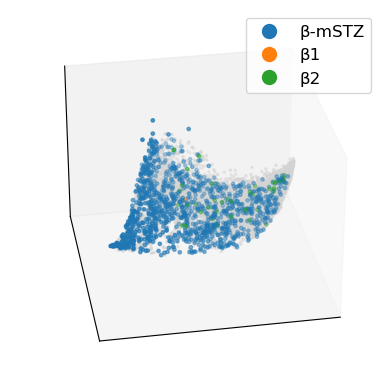

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scprep.plot.scatter3d(data_magic_pc_norm, azim=440, ax=ax, c='lightgray', ticks=None)
scprep.plot.scatter3d(treated_magan_magic_pc_norm, azim=440, ax=ax, c=stz_treated.obs.groups_named_fine)

In [18]:
N_ARCHETYPES = 3

In [19]:
device = torch.device('cpu')
model = models.AAnet_vanilla(noise=0.05, layer_widths=[256, 128],
                             n_archetypes=N_ARCHETYPES, 
                             input_shape=data_magic_pc_norm.shape[1],
                             device=device)

In [20]:
data_loader = torch.utils.data.DataLoader(treated_magan_magic_pc_norm, batch_size=256, shuffle=True, num_workers=4)

In [21]:
model.load_state_dict(torch.load('../analysis_archetypes/results/OB_OB_3_model_state_dict'))

<All keys matched successfully>

In [22]:
archetypal_embedding = model.encode(torch.Tensor(treated_magan_magic_pc_norm))
barycentric_archetypal_embedding = model.euclidean_to_barycentric(archetypal_embedding).detach().numpy()

In [23]:
at_dist = []
for row in barycentric_archetypal_embedding:
    id = np.argwhere(row > 0.5)
    if len(id) == 1:
        at_dist.append('OB/OB AT ' + str(id[0][0]+1))
        
    else:
        at_dist.append('Uncommitted')
        
treated_at_comms = pd.Series(at_dist, index = stz_treated.obs_names)

In [24]:
treated_at_comms.to_csv('results/treated_at_comms_run_2.csv')